# 12 Word World

In [1]:
# Python dependencies
import warnings
import random

# 3rd Party dependencies
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

## Define an Intentionally Limited Vocabulary

We'll train a model with a text that's limited to this vocabulary.

In [3]:
use_verbs = True

adjectives = ["serene", "vibrant", "silent", "endless"]
nouns = ["river", "dream", "mountain", "idea"]
verbs = ["flows", "grows", "whispers", "shines"]

We generate random sentences with those words by randomly concatenating a noun, an adjective and a verb.

In [4]:
sentence_count = 100

if use_verbs:
    twelve_word_world = [
        random.choice(adjectives) + " " + random.choice(nouns) + " " + random.choice(verbs)
        for _ in range(sentence_count)
    ]

if not use_verbs:
    twelve_word_world = [
        random.choice(adjectives) + " " + random.choice(nouns)
        for _ in range(sentence_count)
    ]

In [5]:
from scratch.tokenizers.preprocessor import Preprocessor
from scratch.tokenizers.simple_tokenizer import SimpleTokenizer

def strings_to_text(strings: list[str]):
    return " <|endoftext|> ".join(strings) + " <|endoftext|>"

text_data = strings_to_text(twelve_word_world)

text_data

'endless dream flows <|endoftext|> serene mountain whispers <|endoftext|> silent river shines <|endoftext|> serene dream whispers <|endoftext|> vibrant mountain flows <|endoftext|> serene dream flows <|endoftext|> endless dream flows <|endoftext|> endless mountain flows <|endoftext|> vibrant mountain grows <|endoftext|> serene dream grows <|endoftext|> silent river whispers <|endoftext|> silent mountain grows <|endoftext|> endless river whispers <|endoftext|> serene idea flows <|endoftext|> silent dream shines <|endoftext|> vibrant mountain grows <|endoftext|> serene mountain grows <|endoftext|> endless river grows <|endoftext|> serene river grows <|endoftext|> silent river grows <|endoftext|> silent dream flows <|endoftext|> vibrant river whispers <|endoftext|> endless river flows <|endoftext|> endless dream flows <|endoftext|> silent mountain shines <|endoftext|> vibrant mountain grows <|endoftext|> silent dream whispers <|endoftext|> silent mountain whispers <|endoftext|> vibrant ri

In [6]:
preprocessor = Preprocessor()
source = preprocessor.preprocess(text_data)
tokenizer = SimpleTokenizer(source)

print("Vocabulary size", len(tokenizer.str_to_int))
print("Sentences", len(twelve_word_world))
print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Vocabulary size 14
Sentences 100
Total characters 3524
Total tokens 400


This is our entire vocabulary, including special tokens.

In [7]:
tokenizer.int_to_str

{0: '<|endoftext|>',
 1: '<|unk|>',
 2: 'dream',
 3: 'endless',
 4: 'flows',
 5: 'grows',
 6: 'idea',
 7: 'mountain',
 8: 'river',
 9: 'serene',
 10: 'shines',
 11: 'silent',
 12: 'vibrant',
 13: 'whispers'}

As the sentences have different length depening on whether we enabled, or not, the use of verbs, we need to calculate the context length.

In [8]:
context_length = len(tokenizer.text_to_tokens(twelve_word_world[0] + " <|endoftext|>").squeeze())

context_length

4

## Create a Tiny GPT Model

We instantiate a very tiny model in order to make it quite easy to debug.

In [9]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig(
    vocab_size = len(tokenizer.str_to_int),
    context_length = context_length,
    embedding_dimension = 3,
    head_count = 1,
    layer_count = 1,
    drop_rate = 0,
    qkv_bias = False
)

model = GptModel(config)

model.eval()

GptModel(
  (token_embeddings): Embedding(14, 3)
  (positional_embeddings): Embedding(4, 3)
  (dropout_embeddings): Dropout(p=0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (normalizer): SoftmaxNormalizer()
        (W_query): Linear(in_features=3, out_features=3, bias=False)
        (W_key): Linear(in_features=3, out_features=3, bias=False)
        (W_value): Linear(in_features=3, out_features=3, bias=False)
        (out_proj): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=3, out_features=12, bias=True)
          (1): Gelu()
          (2): Linear(in_features=12, out_features=3, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0, inplace=False)
    )
  )
  (final_normal

In [10]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

240

### Store some Initial Layer States

Now that our model has just been created with random weights, we'll store some of the weights so that we can later compare the initial values with the trained ones.

In [11]:
initial_embeddings = model.token_embeddings.weight.clone().to("cpu")
initial_out_head = model.out_head.weight.clone().to("cpu")

## Preparing the Training and Validation Datasets

In [12]:
train_ratio = 0.9
split_idx = int(train_ratio * len(twelve_word_world))

train_data = strings_to_text(twelve_word_world[:split_idx])
validation_data = strings_to_text(twelve_word_world[split_idx:])

print(validation_data)

endless river grows <|endoftext|> vibrant idea grows <|endoftext|> endless mountain flows <|endoftext|> serene dream whispers <|endoftext|> vibrant idea flows <|endoftext|> endless river grows <|endoftext|> vibrant dream shines <|endoftext|> endless mountain flows <|endoftext|> serene dream flows <|endoftext|> endless idea shines <|endoftext|>


In [13]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
    tokenizer=tokenizer,
)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
    tokenizer=tokenizer,
)

### Checking the Losses before Training

In [14]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 2.779855776916851
Validation loss 2.742499256134033


## Training the Model

### Prepare a Trainer

In [15]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator
from scratch.training.simple_trainer import SimpleTrainer

generator = ProbabilisticTextGenerator(
    model,
    config.context_length,
    temperature = 1.1,
    top_k = 4,
    eos_id = tokenizer.encode("<|endoftext|>")[0]
)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    tokenizer = tokenizer,
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr = 0.05,
        weight_decay = 0.1
    ),
    generator = generator
)

### Run the Training Loop

In [16]:
num_epochs = 10

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 10**10,
    start_context = "silent")


- Step 0
- Train loss 2.748500872742046
- Evaluation loss 2.7173235416412354
- Generated: silent grows dream dream whispers

- Step 50
- Train loss 1.1875848363746295
- Evaluation loss 1.1796652793884277
- Generated: silent mountain whispers

- Step 100
- Train loss 1.1374787972732023
- Evaluation loss 1.2489101886749268
- Generated: silent river shines

- Step 150
- Train loss 1.1133258830417285
- Evaluation loss 1.1511667609214782
- Generated: silent idea whispers

- Step 200
- Train loss 1.0753349268978292
- Evaluation loss 1.1728622436523437
- Generated: silent river whispers

- Step 250
- Train loss 1.1610163707624783
- Evaluation loss 1.3065693378448486
- Generated: silent river flows

- Step 300
- Train loss 1.1139918877319857
- Evaluation loss 1.1264439344406127
- Generated: silent dream whispers

- Step 350
- Train loss 1.0904758166183124
- Evaluation loss 1.2767495155334472
- Generated: silent mountain whispers
- Generated: silent river shines

- Step 400
- Train loss 1.1118

In [17]:
input_text = 'endless'

idx = tokenizer.text_to_tokens(input_text).to(trainer.device)
generated = generator.generate(idx)
tokenizer.tokens_to_text(generated)

'endless mountain whispers'

## Evaluate the Model

### Loss Changes

<Figure size 640x480 with 0 Axes>

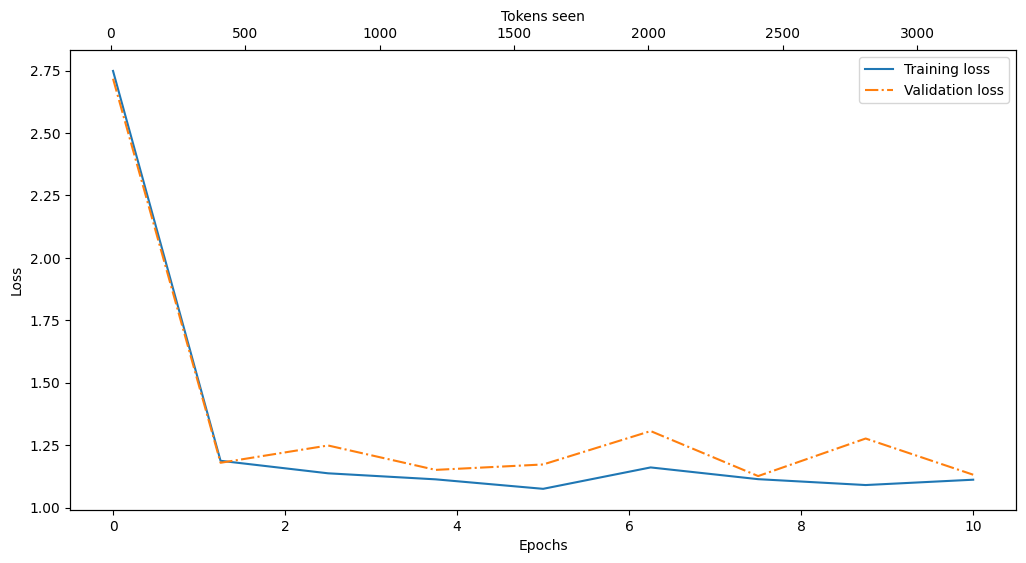

In [18]:
%matplotlib inline

def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    plt.clf()
    fig, ax1 = plt.subplots()

    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

### Embedding Changes

In [19]:
trained_embeddings = model.token_embeddings.weight.clone().to("cpu")

In [20]:
def classify(word: str) -> int:
    if word in adjectives:
        return 0
    if word in nouns:
        return 1
    if word in verbs:
        return 2
    return 3

classes = {
    0: "Adjective",
    1: "Noun",
    2: "Verb",
    3: "Keyword",
}

classification = {token: classify(word) for token, word in tokenizer.int_to_str.items()}
classification

{0: 3,
 1: 3,
 2: 1,
 3: 0,
 4: 2,
 5: 2,
 6: 1,
 7: 1,
 8: 1,
 9: 0,
 10: 2,
 11: 0,
 12: 0,
 13: 2}

In [21]:
colors = {
    0: "tab:blue",
    1: "tab:green",
    2: "tab:red",
    3: "tab:purple",
}

<Figure size 640x480 with 0 Axes>

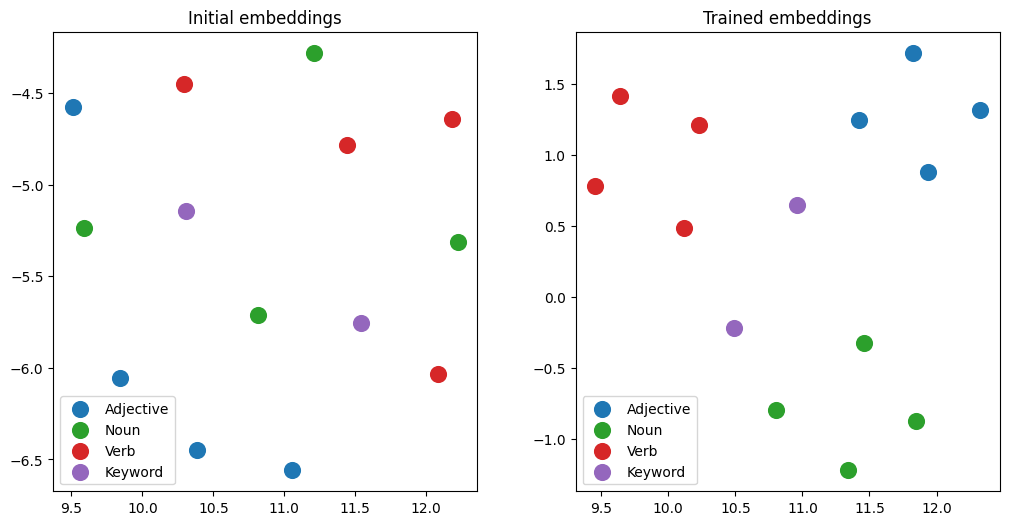

In [22]:
%matplotlib inline

def scat_umap_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    reducer = umap.UMAP(n_components = 2)
    reduced_embeddings = reducer.fit_transform(embeddings.tolist())
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        selection = np.where(groups == group)
        ax.scatter(
            reduced_embeddings[selection][:, 0],
            reduced_embeddings[selection][:, 1],
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_umap_embedding_changes():
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_umap_embeddings(ax1, initial_embeddings, "Initial embeddings")
    scat_umap_embeddings(ax2, trained_embeddings, "Trained embeddings")
    
    plt.show()

plot_umap_embedding_changes()

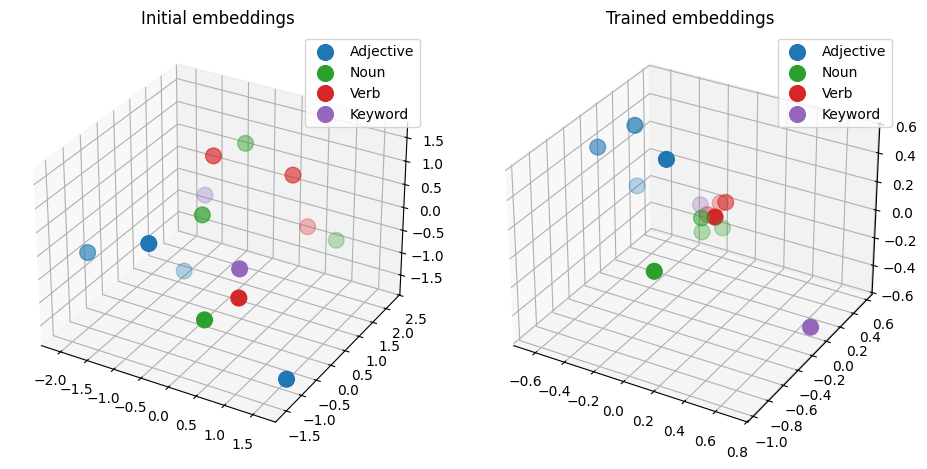

In [23]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

def scat_3d_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        index = np.where(groups == group)
        ax.scatter(
            embeddings[index][:, 0].detach().numpy(),
            embeddings[index][:, 1].detach().numpy(),
            embeddings[index][:, 2].detach().numpy(),
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_3d_embedding_differences():
    plt.clf()
    fig = plt.figure(1, 2)
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_3d_embeddings(ax1, initial_embeddings, "Initial embeddings")
    scat_3d_embeddings(ax2, trained_embeddings, "Trained embeddings")
    
    plt.show()

if initial_embeddings.shape[1] == 3:
    plot_3d_embedding_differences()

### Out Head Changes

In [24]:
trained_out_head = model.out_head.weight.clone().to("cpu")

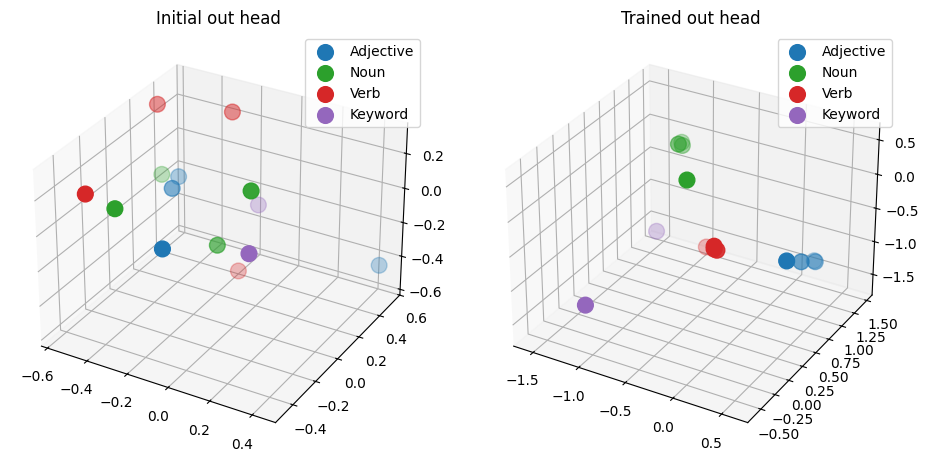

In [27]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

def scat_3d_out_head(ax: Axes, out_head: torch.tensor, title: str):
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        index = np.where(groups == group)
        ax.scatter(
            out_head[index][:, 0].detach().numpy(),
            out_head[index][:, 1].detach().numpy(),
            out_head[index][:, 2].detach().numpy(),
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_3d_out_head_differences():
    plt.clf()
    fig = plt.figure(1, 2)
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_3d_out_head(ax1, initial_out_head, "Initial out head")
    scat_3d_out_head(ax2, trained_out_head, "Trained out head")
    
    plt.show()

if initial_out_head.shape[1] == 3:
    plot_3d_out_head_differences()